In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import date

import warnings
warnings.filterwarnings("ignore")

In [83]:
df = pd.read_csv("../data/water_drinkability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Drinkable
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Data Preprocessing

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Drinkable        3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [85]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Drinkable            0
dtype: int64

In [86]:
df.duplicated().sum()

np.int64(0)

In [87]:
df["ph"] = df["ph"].fillna(df["ph"].mean())
df["Sulfate"] = df["Sulfate"].fillna(df["Sulfate"].mean())
df["Trihalomethanes"] = df["Trihalomethanes"].fillna(df["Trihalomethanes"].mean())

df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Drinkable
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Handling Outliers

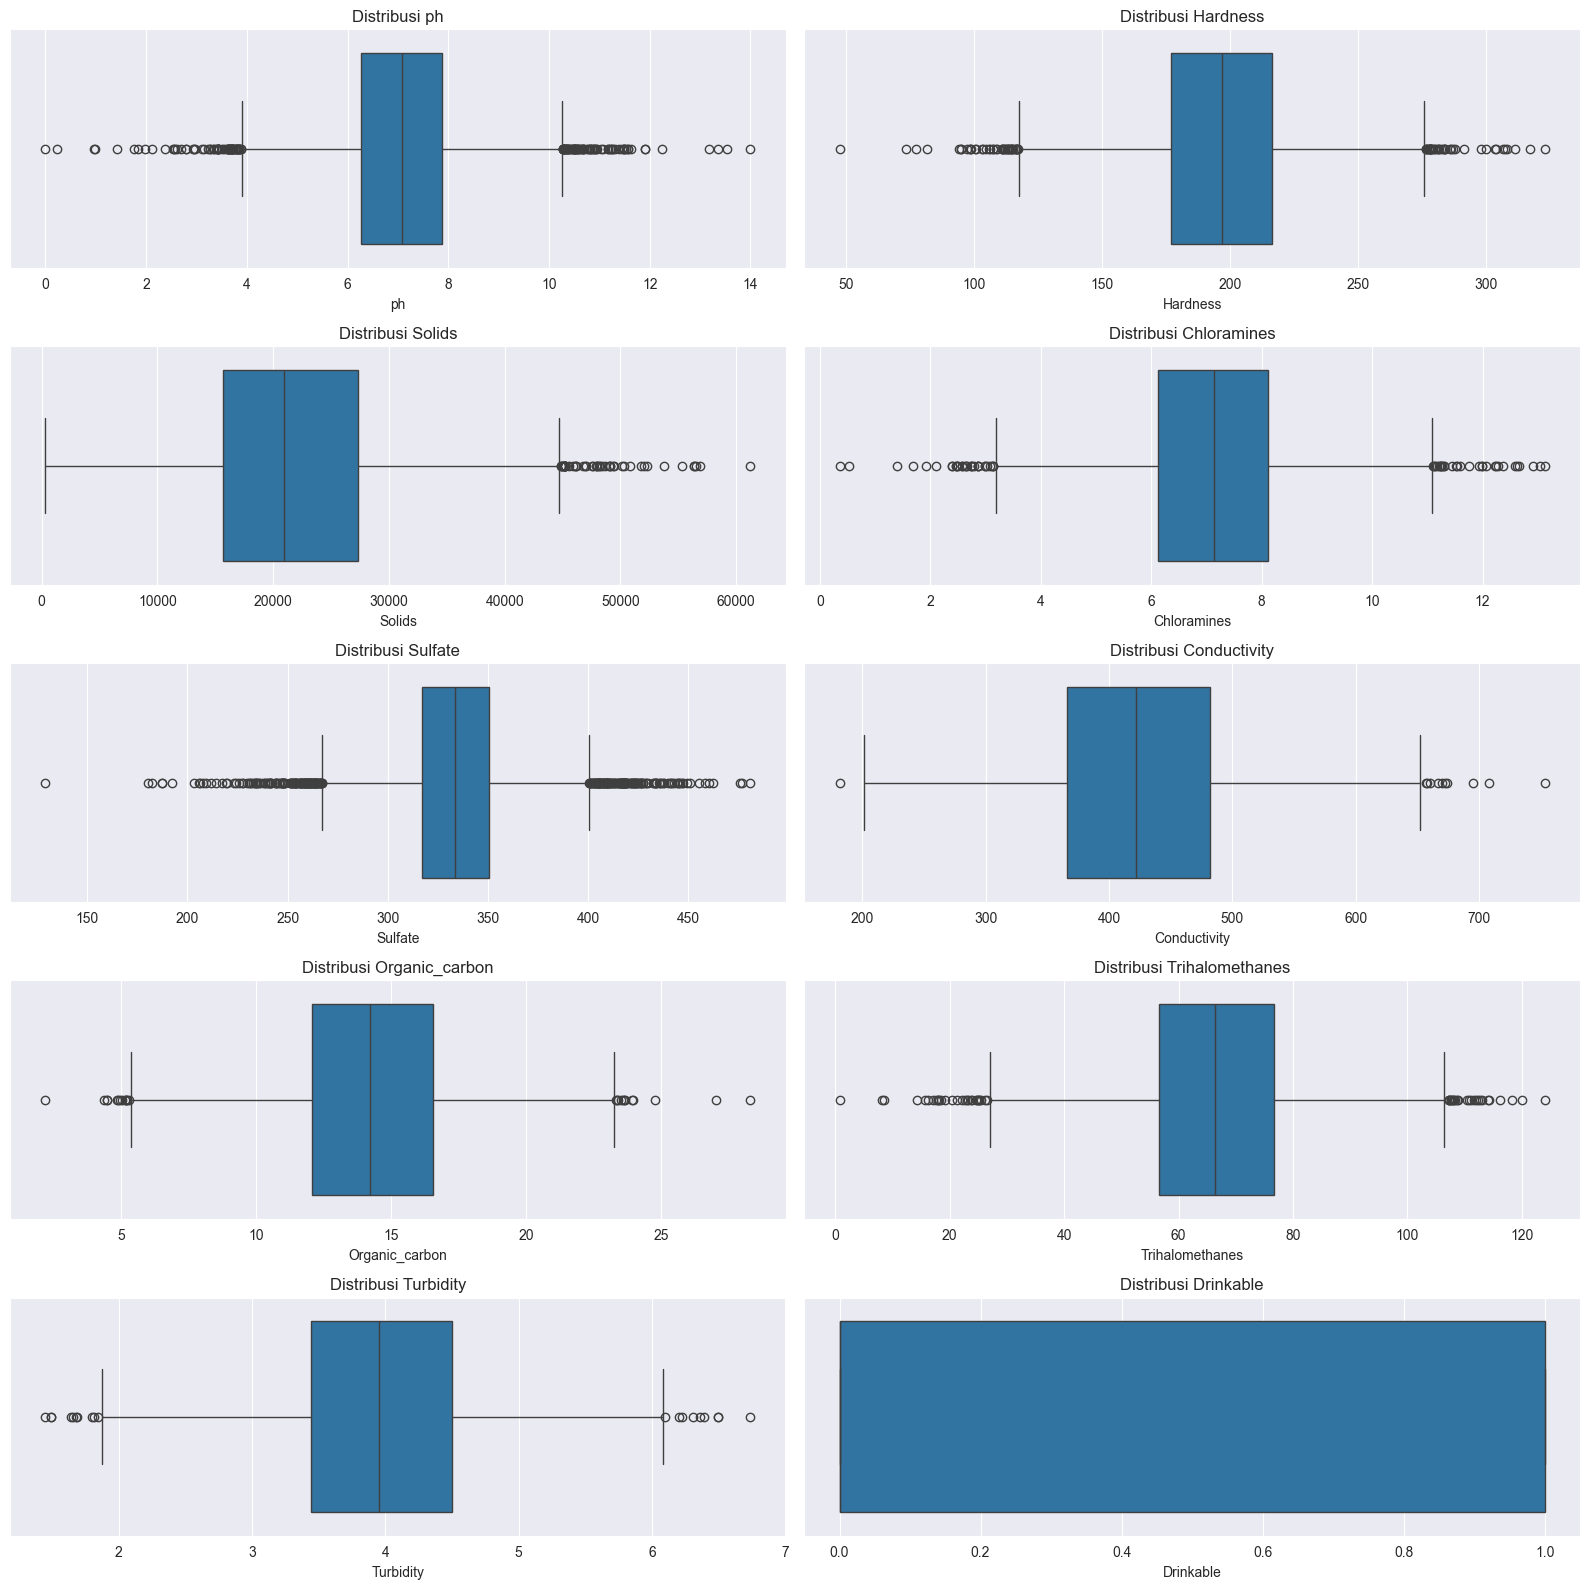

In [88]:
fig,axes = plt.subplots(5,2,figsize = (16,16))
sns.set_style('darkgrid')

for ax, feature in zip(axes.flatten(), df.columns):
    sns.boxplot(data=df, x=feature, ax=ax)
    ax.set_title(f'Distribusi {feature}')

plt.tight_layout()
plt.show()

In [89]:
# KMeansClustering - delete outlier
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans.fit(df)
labels = kmeans.labels_
df = df[labels == labels.max()]
df.reset_index(inplace = True)

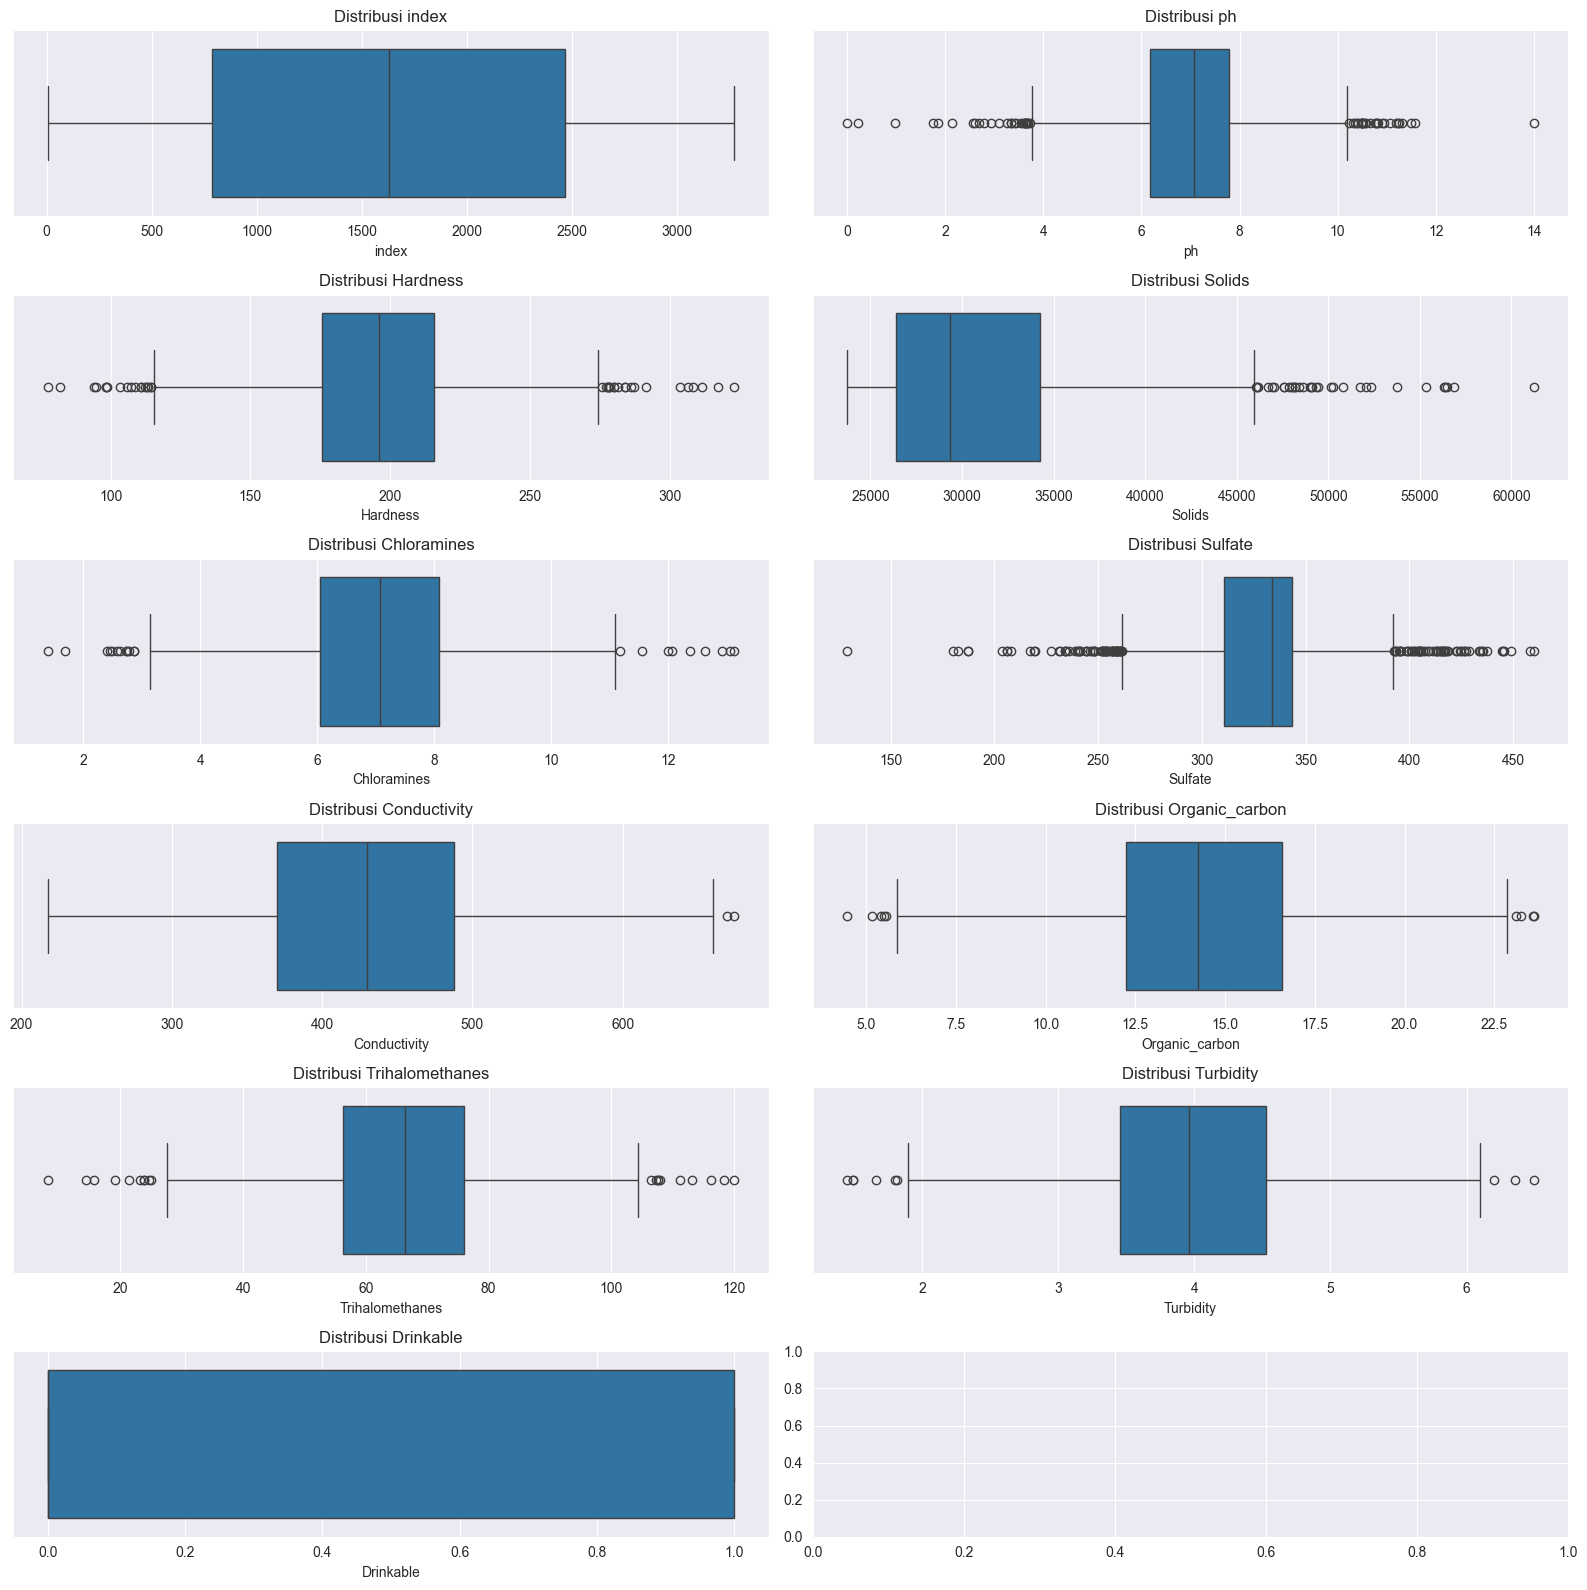

In [90]:
fig,axes = plt.subplots(6,2,figsize = (16,16))
sns.set_style('darkgrid')

for ax, feature in zip(axes.flatten(), df.columns):
    sns.boxplot(data=df, x=feature, ax=ax)
    ax.set_title(f'Distribusi {feature}')

plt.tight_layout()
plt.show()

### Feature Scaling and Divide Dataset

In [91]:
X = df.drop(['Drinkable'],axis=1)
y = df['Drinkable']

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scale= scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X_scale,y,test_size=0.3,random_state=42)

### Feature Selection Method

In [92]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(score_func=mutual_info_classif, k=6)
fs.fit(X_train,y_train)



selected_features = fs.get_support(indices=True)
X_train = X_train[:, selected_features]
X_test = X_test[:, selected_features]
feature_names = X.columns[selected_features]
scores = pd.Series(fs.scores_[selected_features], index=feature_names)
print(scores)

index          0.641104
ph             0.027780
Hardness       0.040635
Chloramines    0.002611
Sulfate        0.027873
Turbidity      0.004147
dtype: float64


### Handle Unbalanced Dataset

In [93]:
y_train.value_counts()

Drinkable
0    532
1    341
Name: count, dtype: int64

In [94]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train,y_train =smote.fit_resample(X_train,y_train)
y_train.value_counts()

Drinkable
0    532
1    532
Name: count, dtype: int64

In [95]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Menghitung akurasi model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred)))

# evaluate the model
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 94.40%
F1 Score: 0.9381
Precision: 0.8933
Recall: 0.9876
ROC AUC Score: 0.9494

Confusion Matrix:
 [[195  19]
 [  2 159]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95       214
           1       0.89      0.99      0.94       161

    accuracy                           0.94       375
   macro avg       0.94      0.95      0.94       375
weighted avg       0.95      0.94      0.94       375



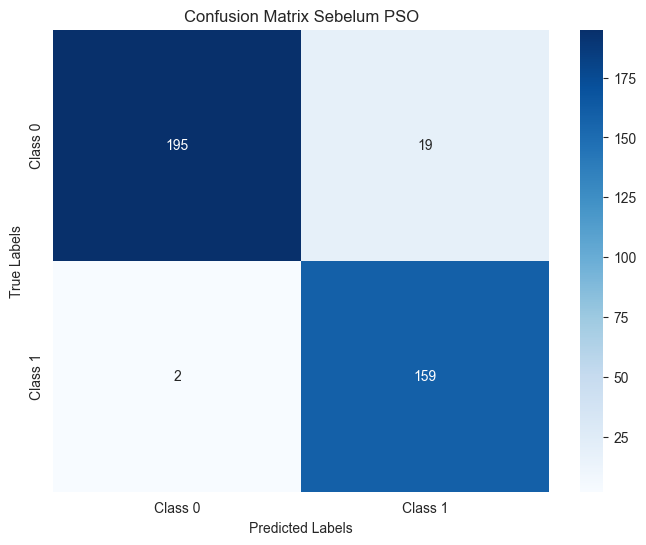

In [96]:
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix Sebelum PSO')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()